## Classifying cats vs dogs via CNN, use a pretrained CNN (VGG16 model)



Large convnet trained on the ImageNet dataset, contains may animal classes including dog and cat
(1.4 million labeled images and 1,000 different classes)

VGG16 image classification model is trained on above dataset


In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.2'

In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
#avoid the fully connected layer from the pretrained model, since we are going to use our own 
#model on top of the base model

In [3]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

### Method 1 : FEATURE EXTRACTION WITHOUT DATA AUGMENTATION


Run conv_base over dataset, recording its output to a numpy array, and then using this data as input to a standalone, densely connected classifier


In [6]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
base_dir=
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory,target_size=(150, 150), batch_size=batch_size,class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch) #extract features from these images by calling the predict
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Look at last layer of convnet;  hence the extracted features are of the size (samples, 4, 4, 512). Need to flatten this to connect to fully connected layers, ie  (samples, 4x 4x512 =8192)

In [7]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [8]:
##now connect the extracted features to fully connected layers
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])
history = model.fit(train_features, train_labels, epochs=30,batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.6101 - acc: 0.6685 - val_loss: 0.4384 - val_acc: 0.8390
Epoch 2/30
2000/2000 [==============================] - 2s 988us/step - loss: 0.4417 - acc: 0.7855 - val_loss: 0.3597 - val_acc: 0.8710
Epoch 3/30
2000/2000 [==============================] - 2s 996us/step - loss: 0.3594 - acc: 0.8425 - val_loss: 0.3226 - val_acc: 0.8750
Epoch 4/30
2000/2000 [==============================] - 2s 985us/step - loss: 0.3225 - acc: 0.8615 - val_loss: 0.3137 - val_acc: 0.8690
Epoch 5/30
2000/2000 [==============================] - 2s 993us/step - loss: 0.2911 - acc: 0.8810 - val_loss: 0.2840 - val_acc: 0.8900
Epoch 6/30
2000/2000 [==============================] - 2s 990us/step - loss: 0.2653 - acc: 0.8925 - val_loss: 0.2709 - val_acc: 0.8970
Epoch 7/30
2000/2000 [==============================] - 2s 987us/step - loss: 0.2434 - acc: 0.9115 - val_loss: 0.2690 - val_acc: 0.8870
Ep

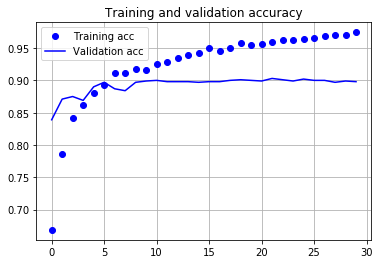

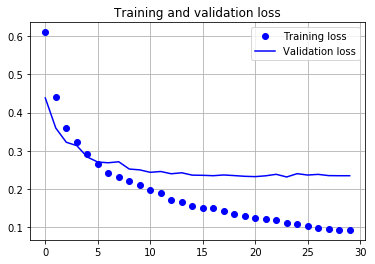

In [12]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.grid()
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid()
plt.show()

validation accuracy reaches about 90%. However, the plots also indicate that we are overfitting despite using dropout
with a fairly large rate. We have to use data augmentation, which is essential to preventing overfitting with small image datasets.

### Method 2 : FEATURE EXTRACTION WITH DATA AUGMENTATION

much slower, computationally expensive

we train the model end to end with a frozen convolutional base
    